In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error

## Cross-validation

Previously, we've seen why it's important to split our dataset into a train and a test split, in order to more fairly assess the usefullness of our model. We saw that the performance metrics (loss) on the train data is, in itself, a bad assessement of this and that good performance on the train set does not imply good performance on the test set.

In any case, we've also seen now that even this data splitting strategy has its limits, since we sometime can get lucky (or unlucky, depending on how you look at it) with how this split occurs. If we get a particularly bad split, we might obtain really good performance on the test set on models that otherwise are severly overfit or underfit to our data.

To bypass this, we'll be using **k-fold cross-validation**. 

This is a very simple generalisation of the train and test split strategy, where we just construct *k* seperate splits of our full dataset into *k* different train and test splits.

The idea is then to fit our model (with the chosen features) on each of these *k* different train/test splits and average the performance over each. This newly obtained perfromance average is then usually a much better assessement of the model's (with the given features) true performance.

Simply put, here are the steps for *k*-fold cross validation:

    1. 
Construct *k* different train and test splits from our full data. 
    
    2. 
Train our model, with the given features, on each of the *k* different train and test splits.
    
    3. 
Calculate the performance metric after training (could e.g., be MAE).
    
    4. 
Average the MAE over the *k* different training runs.

Usual values for *k* is somwhere around 5 or 10. Chosing larger values for *k* provides better estimates, but brings about larger compute costs.

---

**Implementation**

Let's first import our dataset. We'll use the bike demand dataset from the previous lab.

We'll skip all the data analysis, data cleaning and feature engineering here so that we can
showcase cross-validation instead.

In [27]:
df = pd.read_csv('../data/bike/day.csv')

df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


In [28]:
# drop unwanted and forbidden columns (why are casual and registered forbidden here?)

df = df.drop(columns=['instant', 'dteday', 'casual', 'registered'])

df

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
726,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,2114
727,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,3095
728,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,1341
729,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,1796


In [29]:
# seperate features and target

X, y = df.drop(columns=['cnt']), df['cnt']

**Excplicit implementation of k-fold cross-validation**

Here's an explicit implementation of k-fold cross validation

In [30]:
# Initialize list to store MAE values
mae_values = []

# Define the number of folds
num_folds = 10

# Loop through each fold

for fold in range(num_folds):
    
    # for each fold, create a random train/test split

    # NOTE, there are different philosophies for how to chose the test size here. 
    
    # 1. We can keep it constant throughout each fold or

    # 2. As some like to do it, choose the test size to be 1/num_folds
    # chosing num_folds = 5 then means a test size of 0.2 = 20%. 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/num_folds)
    
    # Initialize linear regression model
    model = LinearRegression()
    
    # Train the model using X_train and y_train
    model.fit(X_train, y_train)
    
    # Make predictions
    y_test_hats = model.predict(X_test)
    
    # Calculate Root Mean Absolute Error
    mae = mean_absolute_error(y_test, y_test_hats)
    
    # Append MSE to list
    mae_values.append(mae)

# Print MAE values for each fold
for i, mae in enumerate(mae_values):
    print(f"Fold {i+1} MAE: {mae}")

print()
print('Average MAE:', np.mean(mae_values))

Fold 1 MAE: 581.6725570355158
Fold 2 MAE: 644.718450142133
Fold 3 MAE: 600.3918168921972
Fold 4 MAE: 750.354794998026
Fold 5 MAE: 651.2955413279682
Fold 6 MAE: 571.2171257255765
Fold 7 MAE: 743.8231103929986
Fold 8 MAE: 670.2975358067649
Fold 9 MAE: 611.5919632503171
Fold 10 MAE: 727.7222616834176

Average MAE: 655.3085157254916


**Make it a function**

In [31]:
from sklearn.metrics import mean_absolute_error


def my_cross_validator(model, X, y, evaluation_function, num_folds, test_size):

    loss_test_values = []
    loss_train_values = []

    for fold in range(num_folds):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)   # notera att detta skapar en helt random uppdelning av train/test split
                                                                                         # för varje loop - vilket är precis vad vi vill.
        model.fit(X_train, y_train)

        y_test_hats = model.predict(X_test)
        y_train_hats = model.predict(X_train)

        test_loss = evaluation_function(y_test, y_test_hats)
        train_loss = evaluation_function(y_train, y_train_hats)

        loss_test_values.append(test_loss)
        loss_train_values.append(train_loss)

    return loss_test_values, loss_train_values

In [32]:
model = LinearRegression()
num_folds = 5
test_size = 0.2

test_losses, train_losses = my_cross_validator(model, X, y, mean_absolute_error, num_folds, test_size)


print('test:')
print(test_losses, end='\n\n')
print('test average:')
print(np.mean(test_losses), end='\n\n')

print('train:')
print(train_losses, end='\n\n' )
print('train average:')
print(np.mean(train_losses))

test:
[672.7971212510172, 779.6249099577785, 654.5045159300178, 577.0503631764435, 696.5258486188927]

test average:
676.10055178683

train:
[638.8040288597996, 610.6367569657117, 650.6381905455274, 666.1276173677606, 634.7686951019859]

train average:
640.1950577681571


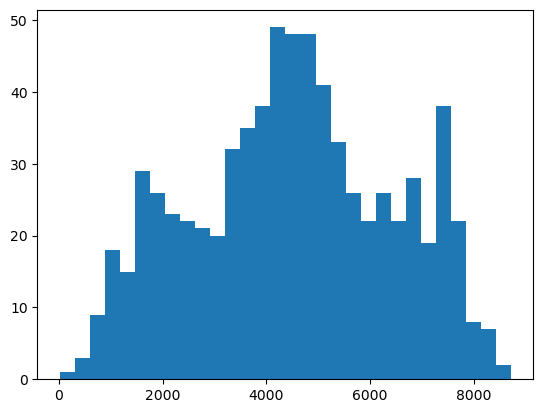

In [33]:
import matplotlib.pyplot as plt

plt.hist(y, bins=30)
plt.show()

**Using Sklearn**

In [34]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error


# Initialize linear regression model
model = LinearRegression()

# Define the scoring function
scoring = {'mae': make_scorer(mean_absolute_error),
           'mse': make_scorer(mean_squared_error)}

# Perform 5-fold cross-validation
num_folds = 5

cv_results = cross_validate(model, X, y, cv=num_folds, scoring=scoring, return_train_score=True)

In [35]:
# Extract MAE values for each fold
mae_values = cv_results['test_mae']

# Print MAE values for each fold
for i, mae in enumerate(mae_values):
    print(f"Fold {i+1} MAE: {mae}")

print()
print('Average MAE:', np.mean(cv_results['test_mae']))

Fold 1 MAE: 570.5941983602208
Fold 2 MAE: 801.7763581756303
Fold 3 MAE: 731.548154317967
Fold 4 MAE: 908.8770556825804
Fold 5 MAE: 865.4749609748525

Average MAE: 775.6541455022501


**To learn more about sklearns own cross-validators, read the documentation**

You can either use:

1. The function **cross_validation**, which we used above
Documentation [here.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html)

2. The function **cross_val_score**
Documentation [here.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

---

**How to use this**

We use cross validation to assess the perfromance of *every* model and feature(s) pair!

For example, assume we have two models, each called model_1 and model_2, respectively.

Assume also that we now have features $x_1, x_2, x_3, x_4$.

We now want to find out which model and feature combination that produces the pest result on our data.

For starters, say that we want to assess model_1 combined with features $x_1, x_2$ and $x_3$.

We then do a full 5-fold cross-validation on this model with this features. In other words:

Let X consist of $x_1, x_2, x_3$.

Then, we simply

cv_results = cross_validate(model_1, X, y, cv=5, scoring=scoring).

and therafter calculate

combination_average_performance = np.mean(cv_results['test_mae'])

This resulting average is what we use to compare performance with any other model and feature combination!


---

## Challanges

**Task**

Try using cross-validation to assess performance on the bike demand dataset using a linear model combined with different sets of features.

You can use whichever method to cross-valdiate we've shown above, as you like.

In [39]:
df = pd.read_csv('../data/bike/day.csv')
df = df.drop(columns=["instant", "dteday", "casual", "registered"])
df

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,985
1,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,801
2,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1349
3,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1562
4,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
726,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,2114
727,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,3095
728,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,1341
729,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,1796


In [44]:
X, y = df.drop(columns=["season", "cnt", "holiday", "windspeed", "atemp"]), df['cnt']
# Initialize linear regression model
model_1 = LinearRegression()

# Define the scoring function
scoring = {'mae': make_scorer(mean_absolute_error),
           'mse': make_scorer(mean_squared_error)}

# Perform 5-fold cross-validation
num_folds = 5

cv_results = cross_validate(model_1, X, y, cv=num_folds, scoring=scoring, return_train_score=True)

# Extract MAE values for each fold
mae_values = cv_results['test_mae']

# Print MAE values for each fold
for i, mae in enumerate(mae_values):
    print(f"Fold {i+1} MAE: {mae}")

print()
print('Average MAE:', np.mean(cv_results['test_mae']))

Fold 1 MAE: 541.8204646196693
Fold 2 MAE: 841.4806034975363
Fold 3 MAE: 838.2769703835532
Fold 4 MAE: 905.4723997000144
Fold 5 MAE: 998.1299535950685

Average MAE: 825.0360783591683
